In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sentence_transformers import SentenceTransformer

from sklearn.datasets import make_blobs
from OnlineKMeans import OnlineKMeans

/opt/anaconda3/envs/tdk_szakdoga/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
categories = ["sci.space", "rec.sport.hockey", "comp.graphics", "talk.politics.mideast"]
newsgroups = fetch_20newsgroups(subset="train", categories=categories, remove=("headers", "footers", "quotes"))

In [3]:
docs = newsgroups.data
labels = newsgroups.target

In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(docs, show_progress_bar=True, convert_to_numpy=True)

Batches: 100%|██████████| 74/74 [00:09<00:00,  7.61it/s]


In [5]:
kmeans = KMeans(n_clusters=len(categories), random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
dbscan = DBSCAN(eps=0.1, min_samples=5, metric="cosine")
dbscan_labels = dbscan.fit_predict(embeddings)

In [8]:
def evaluate_clustering(true_labels, pred_labels, method):
    mask = pred_labels != -1  # DBSCAN may assign -1 (noise)
    if np.sum(mask) == 0:
        print(f"{method}: all points noise!")
        return
    ari = adjusted_rand_score(np.array(true_labels)[mask], pred_labels[mask])
    nmi = normalized_mutual_info_score(np.array(true_labels)[mask], pred_labels[mask])
    print(f"{method} → ARI: {ari:.3f}, NMI: {nmi:.3f}, Coverage: {np.mean(mask):.2f}")

evaluate_clustering(labels, kmeans_labels, "KMeans")
evaluate_clustering(labels, dbscan_labels, "DBSCAN")

KMeans → ARI: 0.685, NMI: 0.684, Coverage: 1.00
DBSCAN → ARI: 0.000, NMI: 0.000, Coverage: 0.03


In [9]:
np.unique(dbscan_labels)

array([-1,  0])

# v0 online kmeans

In [6]:
# ---------- 1. Generate synthetic dataset ----------
X, y_true = make_blobs(n_samples=1000, centers=4, cluster_std=0.6, random_state=42)

In [7]:
# ---------- 2. Online KMeans class ----------
class OnlineKMeans:
    def __init__(self, n_clusters=4, learning_rate=0.5, random_state=None):
        self.n_clusters = n_clusters
        self.learning_rate = learning_rate
        self.random_state = np.random.RandomState(random_state)
        self.centroids = None

    def initialize_centroids(self, X):
        idx = self.random_state.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[idx]

    def partial_fit(self, X_batch):
        if self.centroids is None:
            self.initialize_centroids(X_batch)

        for x in X_batch:
            # assign to nearest centroid
            distances = np.linalg.norm(self.centroids - x, axis=1)
            k = np.argmin(distances)
            # update centroid with learning rate
            self.centroids[k] = (1 - self.learning_rate) * self.centroids[k] + self.learning_rate * x

    def predict(self, X):
        distances = np.linalg.norm(self.centroids[None, :, :] - X[:, None, :], axis=2)
        return np.argmin(distances, axis=1)

In [8]:
# ---------- 3. Train normal KMeans ----------
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
y_kmeans = kmeans.fit_predict(X)

In [9]:
# ---------- 4. Train Online KMeans ----------
online = OnlineKMeans(n_clusters=4, learning_rate=0.3, random_state=42)

# simulate streaming in small batches
batch_size = 20
for i in range(0, len(X), batch_size):
    online.partial_fit(X[i:i+batch_size])

y_online = online.predict(X)

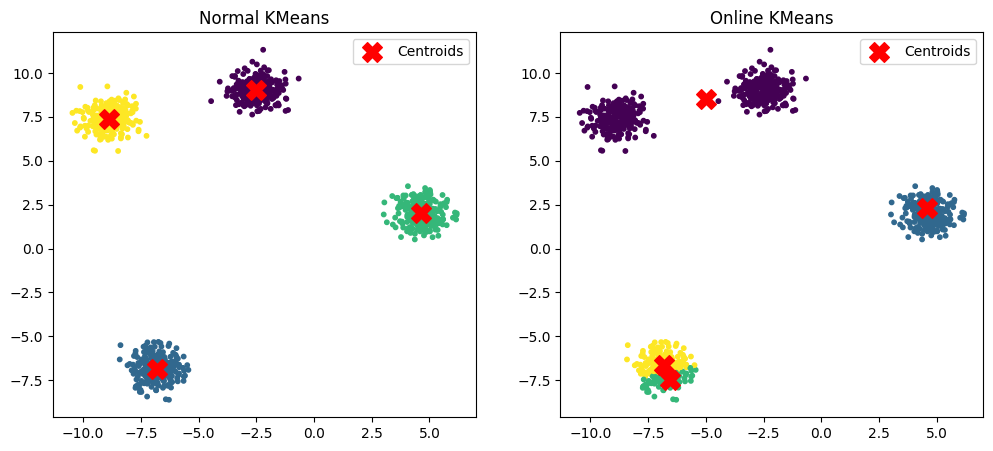

In [10]:
# ---------- 5. Visualization ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Normal KMeans
axs[0].scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap="viridis", s=10)
axs[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               c="red", marker="X", s=200, label="Centroids")
axs[0].set_title("Normal KMeans")
axs[0].legend()

# Online KMeans
axs[1].scatter(X[:, 0], X[:, 1], c=y_online, cmap="viridis", s=10)
axs[1].scatter(online.centroids[:, 0], online.centroids[:, 1],
               c="red", marker="X", s=200, label="Centroids")
axs[1].set_title("Online KMeans")
axs[1].legend()

plt.show()

# v1 online kmeans

Batch KMeans ARI: 0.886
Online Improved ARI: 0.849


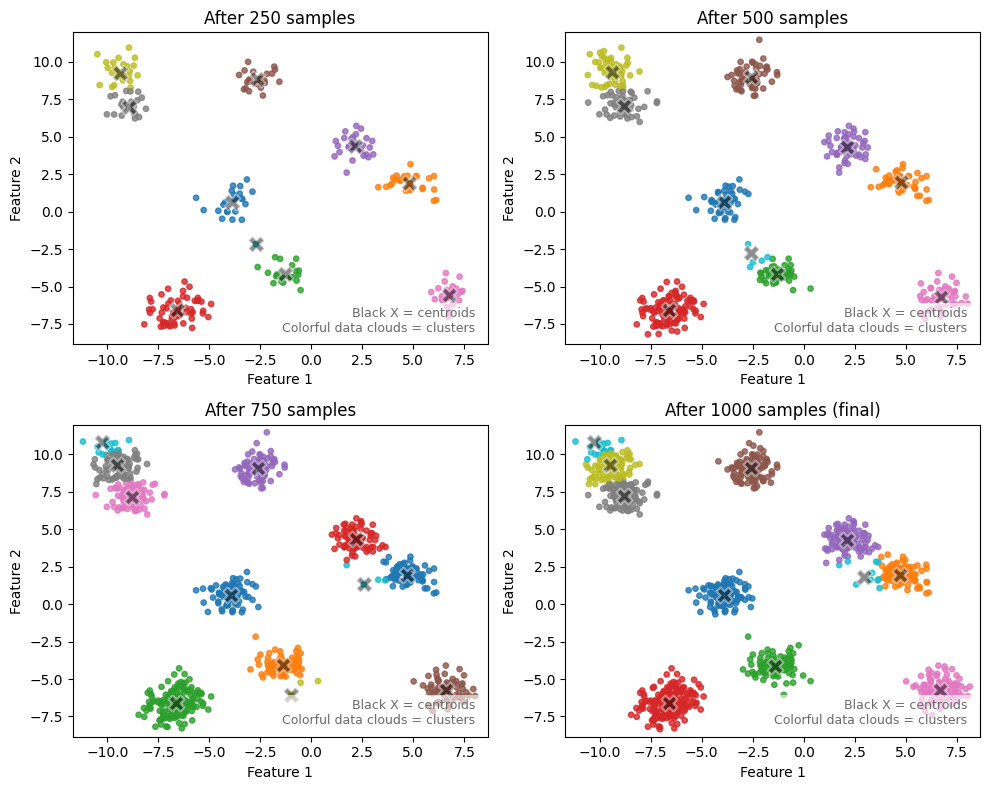

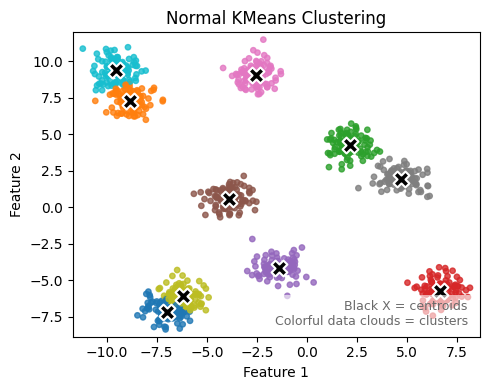

In [10]:
n_clusters = 10

# ---- Generate data ----
X, y_true = make_blobs(
    n_samples=1000, centers=n_clusters, cluster_std=0.64,
    random_state=42, n_features=2
)

# ---- Batch KMeans reference ----
kmeans_batch = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(X)
y_batch = kmeans_batch.labels_

# ---- Online KMeans Improved (your implementation) ----
online = OnlineKMeans(
    n_clusters=n_clusters // 2,
    max_clusters=2*n_clusters,
    metric="euclidean",
    new_cluster_threshold=2.0, # 2.0
    merge_threshold=1.7, #1.7
    random_state=42,
)

# ---- Stream simulation ----
batch_size = 25
snapshots = []

# exact quarter checkpoints for 1000 samples
checkpoints = [250, 500, 750, 1000]
captured = set()
samples_seen = 0

for i in range(0, len(X), batch_size):
    batch = X[i : i + batch_size]
    online.partial_fit(batch)
    samples_seen += len(batch)

    # capture snapshot when we reach or pass a checkpoint
    for cp in checkpoints:
        if samples_seen >= cp and cp not in captured:
            labels_now = online.predict(X)
            snapshots.append((cp, np.copy(online.centroids), labels_now))
            captured.add(cp)

# ---- Evaluate ----
_, _, labels_final = snapshots[-1]
ari_batch = adjusted_rand_score(y_true, y_batch)
ari_online = adjusted_rand_score(y_true, labels_final)
print(f"Batch KMeans ARI: {ari_batch:.3f}")
print(f"Online Improved ARI: {ari_online:.3f}")

# ---- Plot 1: Online KMeans evolution (2x2 grid) ----
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

titles = [
    f"After {snapshots[0][0]} samples",
    f"After {snapshots[1][0]} samples",
    f"After {snapshots[2][0]} samples",
    f"After {snapshots[3][0]} samples (final)",
]

for ax, (step, centroids, labels_now), title in zip(axs, snapshots, titles):
    # only plot the samples that have been processed so far
    X_seen = X[:step]
    labels_seen = labels_now[:step]

    ax.scatter(X_seen[:, 0], X_seen[:, 1], c=labels_seen, s=15, alpha=0.8, cmap='tab10')
    ax.scatter(
        centroids[:, 0], centroids[:, 1],
        c='black', s=130, marker='X',
        edgecolors='white', linewidths=1.5, alpha=0.45
    )
    ax.set_title(title)
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.text(
        0.97, 0.03,
        "Black X = centroids\nColorful data clouds = clusters",
        transform=ax.transAxes,
        fontsize=9,
        color="dimgray",
        ha="right", va="bottom",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=3)
    )

plt.tight_layout()
# plt.savefig("./plots/online_clustering_flow/online_clustering_flow.png", dpi=300)
plt.show()

# ---- Plot 2: Batch KMeans final state ----
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], c=y_batch, s=15, alpha=0.8, cmap='tab10')
plt.scatter(
    kmeans_batch.cluster_centers_[:, 0],
    kmeans_batch.cluster_centers_[:, 1],
    c='black', s=130, marker='X',
    edgecolors='white', linewidths=1.5
)
plt.title("Normal KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.text(
    0.97, 0.03,
    "Black X = centroids\nColorful data clouds = clusters",
    transform=plt.gca().transAxes,
    fontsize=9,
    color="dimgray",
    ha="right", va="bottom",
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=3)
)
plt.tight_layout()
# plt.savefig("./plots/online_clustering_flow/batch_kmeans.png", dpi=300)
plt.show()

In [3]:
embeddings = np.load("./data/tensors/squad_train_v2_semantic_chunking_l2.npy")

In [4]:
embeddings.shape

(84007, 384)

In [5]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

def online_kmeans_clustering(
    chunk_embeddings,
    n_clusters=20,
    batch_size=500,
    init_fraction=0.5,  # fraction of data used for initialization
    max_clusters=None,
    metric="cosine",
    new_cluster_threshold=None,
    merge_threshold=None
):
    n_samples = chunk_embeddings.shape[0]
    init_size = int(n_samples * init_fraction)
    remaining_size = n_samples - init_size

    print(f"🔧 Using {init_fraction*100:.0f}% of data ({init_size} samples) for initialization")

    # --- Step 1: Initialization ---
    init_start = time.time()
    okm = OnlineKMeans(
        n_clusters=n_clusters,
        max_clusters=max_clusters,
        metric=metric,
        new_cluster_threshold=new_cluster_threshold,
        merge_threshold=merge_threshold,
        random_state=42
    )
    okm.partial_fit(chunk_embeddings[:init_size])
    init_time = time.time() - init_start
    print(f"✅ Initialization done in {init_time:.4f} s")

    # --- Step 2: Online updates ---
    results = []
    for batch_idx in tqdm(range(1, int(np.ceil(remaining_size / batch_size)) + 1)):
        start_idx = (batch_idx - 1) * batch_size
        end_idx = min(batch_idx * batch_size, remaining_size)
        batch_embeddings = chunk_embeddings[init_size + start_idx : init_size + end_idx]

        update_start = time.time()
        okm.partial_fit(batch_embeddings)
        update_time = time.time() - update_start

        results.append({
            "batch": batch_idx,
            "init_time": init_time if batch_idx == 1 else 0,
            "update_time": update_time,
            "n_clusters": len(okm.centroids)
        })

    # --- Final labels ---
    final_labels = okm.predict(chunk_embeddings)
    results_df = pd.DataFrame(results)

    return {
        "model": okm,
        "labels": final_labels,
        "results_df": results_df
    }


In [6]:
results = online_kmeans_clustering(
    embeddings,
    n_clusters=360,
    batch_size=2000,
    init_fraction=0.5,
    max_clusters=2000,
    metric="cosine",
    new_cluster_threshold=0.8,
    merge_threshold=0.08
)

🔧 Using 50% of data (42003 samples) for initialization
✅ Initialization done in 7.3029 s


100%|██████████| 22/22 [00:00<00:00, 50.39it/s]


In [7]:
okm = results["model"]

In [8]:
len(okm.get_state()['counts'])

468

In [9]:
okm.get_state()['counts'].mean()

np.float64(179.50213675213675)